# Testing LOSD
### Bevölkerung nach Konfession, seit 1934

Wirtschaftliche Wohnbevölkerung der Stadt Zürich nach Religion und Jahr, seit 1934.

https://data.integ.stadt-zuerich.ch/dataset/bev316od3160

Datum: 15.03.2024

### Colab
Mit Colab kann das Jupyter-Notebook interaktiv im Browser gestartet werden. 

Klicke auf den Button:
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/DonGoginho/colab/blob/main/losd/3160_losd_bev_bestand_jahr_konfession_od3160.ipynb)


### Importiere die notwendigen Packages

In [1]:
#%pip install altair datetime folium geopandas io requests matplotlib numpy pandas seaborn plotly
import ipykernel
print(ipykernel.__version__)

import sys
import platform
print("Python-Version:", sys.version)
print("Python-Implementierung:", platform.python_implementation())
print("Python-Build:", platform.python_build())
print("Python-Compiler:", platform.python_compiler())


6.29.3
Python-Version: 3.11.8 | packaged by Anaconda, Inc. | (main, Feb 26 2024, 21:34:05) [MSC v.1916 64 bit (AMD64)]
Python-Implementierung: CPython
Python-Build: ('main', 'Feb 26 2024 21:34:05')
Python-Compiler: MSC v.1916 64 bit (AMD64)


In [2]:
import altair as alt
import datetime
import folium 
import geopandas as gpd
import io
from IPython.display import Markdown as md
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import pivottablejs
#from pivottablejs import pivot_ui
import plotly.express as px
import requests
import seaborn as sns

In [3]:
import sys
sys.path.append('../0_scripts')

import my_py_dataviz_functions as mypy_dv
import my_py_dataloading_functions as mypy_dl

In [4]:
SSL_VERIFY = False
# evtl. SSL_VERIFY auf False setzen wenn die Verbindung zu https://www.gemeinderat-zuerich.ch nicht klappt (z.B. wegen Proxy)
# Um die SSL Verifikation auszustellen, bitte die nächste Zeile einkommentieren ("#" entfernen)
# SSL_VERIFY = False

In [5]:
if not SSL_VERIFY:
    import urllib3
    urllib3.disable_warnings()

### Settings
Definiere Settings. 
Hier das Zahlenformat von Float-Werten (z.B. *'{:,.2f}'.format* mit Komma als Tausenderzeichen)

In [6]:
#pd.options.display.float_format = lambda x : '{:,.1f}'.format(x) if (np.isnan(x) | np.isinf(x)) else '{:,.0f}'.format(x) if int(x) == x else '{:,.1f}'.format(x)
pd.options.display.float_format = '{:.0f}'.format
pd.set_option('display.width', 100)
pd.set_option('display.max_columns', 15)

#### Zeitvariabeln

In [7]:
#Zeitvariabeln als Strings:
now = datetime.date.today()
year_today = now.strftime("%Y")
date_today = "_"+now.strftime("%Y-%m-%d")

#Zeitvariabeln als Integers:
int_times = now.timetuple()
aktuellesJahr = int_times[0]
aktuellerMonat = int_times[1]
selectedMonat = int_times[1]-2
#print(aktuellesJahr, aktuellerMonat,'datenstand: ', selectedMonat, int_times)

### Daten importieren und Metadaten checken

- status: int / prod
- data_source: web / ld / dropzone
- datums_attr: beschreibt das oder die Datumsfelder, die als Datum geparsed werden sollen. Falls es keines gibt: None

**BITTE HIER ANPASSEN**

In [11]:
#speichere die variable global, damit ich sie später verwenden kann, wenn ich grafiken mit diesem namen speichere.
package_name = "bev316od3160"

In [12]:
data2betested = mypy_dl.load_data(
    status = 'int'
    , data_source = 'ld'
    , package_name = package_name
    , dataset_name = "bev316od3160.csv"    
    , datums_attr = ['ZEIT_LANG']
    )

fp lautet:https://ld.integ.stadt-zuerich.ch/statistics/view/BEV316OD3160/observation?format=csv


 **Überprüfe die Metadaten:**

 **Dataset auf INTEG-Datakatalog:** Link https://data.integ.stadt-zuerich.ch/dataset/bev316od3160 

 **View auf INTEG-LD:** Link https://ld.integ.stadt-zuerich.ch/statistics/view/BEV316OD3160 

Es ist ein Fehler aufgetreten: No columns to parse from file


Error: No columns to parse from file



In [10]:
data2betested.head(2)

AttributeError: 'NoneType' object has no attribute 'head'

In [ ]:
data2betested.sort_values("ZEIT_LANG", ascending=False).head(2)

AttributeError: 'NoneType' object has no attribute 'sort_values'

Berechne weitere Attribute falls notwendig

`ACHTUNG`!

In Pandas kann `datetime` Daten ab dem Jahr **1677** speichern. Das liegt daran, dass Pandas datetime64[ns] auf der Basis von NumPy verwendet, das wiederum den Datentyp datetime64 bereitstellt, der auf dem Standard des Proleptischen Gregorianischen Kalenders basiert. Dieser Kalender geht bis zum Jahr 1677 zurück.

Alternative: Abfangen des Problems mit Funktion:

-----------------------------------------------

In [ ]:
def convert_to_datetime(date_str):
    try:
        date = pd.to_datetime(date_str)
        if date.year < 1677:
            raise ValueError("Datum liegt außerhalb des gültigen Bereichs für datetime-Objekte.")
        return date
    except ValueError:
        return pd.NaT  # Falls ein ungültiges Datum übergeben wurde, gib NaT (Not a Timestamp) zurück


-------------------------------------------------------

In [ ]:
data2betested = (
    data2betested
    .copy()
    .assign(
        StichtagDatJahr = lambda x: x.ZEIT_LANG.apply(convert_to_datetime),
        #StichtagDatJahr = lambda x: x.ZEIT_lang,
        StichtagDatJahr_str = lambda x: x.ZEIT_LANG.astype(str),
        #Jahr = lambda x: x.ZEIT_lang.dt.year,
        Jahr_nbr = lambda x: x.ZEIT_CODE.str[-4:].astype(int),    
        RAUM_my_sort = lambda x: x.ZEIT_CODE.str[1:].astype(int),

    )
    .sort_values('ZEIT_LANG', ascending=False)
    )
data2betested

,ZEIT_LANG,ZEIT_CODE,RAUM_LANG,RAUM_CODE,KON_LANG,KON_CODE,BEW,StichtagDatJahr,StichtagDatJahr_str,Jahr_nbr,RAUM_my_sort
52,2023-12-31,Z31122023,Stadt Zürich (ab 1934),R30000,"Andere, ohne, unbekannt",KON9900,275174,2023-12-31,2023-12-31,2023,31122023
157,2023-12-31,Z31122023,Stadt Zürich (ab 1934),R30000,Römisch-katholische Kirche,KON2001,97639,2023-12-31,2023-12-31,2023,31122023
258,2023-12-31,Z31122023,Stadt Zürich (ab 1934),R30000,Evangelisch-reformierte Kirche,KON1001,74269,2023-12-31,2023-12-31,2023,31122023
40,2022-12-31,Z31122022,Stadt Zürich (ab 1934),R30000,Römisch-katholische Kirche,KON2001,102074,2022-12-31,2022-12-31,2022,31122022
204,2022-12-31,Z31122022,Stadt Zürich (ab 1934),R30000,"Andere, ohne, unbekannt",KON9900,263856,2022-12-31,2022-12-31,2022,31122022
...,...,...,...,...,...,...,...,...,...,...,...
73,1934-12-31,Z31121934,Stadt Zürich (ab 1934),R30000,Evangelisch-reformierte Kirche,KON1001,208357,1934-12-31,1934-12-31,1934,31121934
240,1930-12-31,Z31121930,Stadt Zürich (ab 1934),R30000,Evangelisch-reformierte Kirche,KON1001,189773,1930-12-31,1930-12-31,1930,31121930
2,1920-12-31,Z31121920,Stadt Zürich (ab 1934),R30000,Evangelisch-reformierte Kirche,KON1001,155027,1920-12-31,1920-12-31,1920,31121920
25,1910-12-31,Z31121910,Stadt Zürich (ab 1934),R30000,Evangelisch-reformierte Kirche,KON1001,139649,1910-12-31,1910-12-31,1910,31121910


Minimales und maximales Jahr im Datensatz

In [ ]:
data_max_date = str(max(data2betested.StichtagDatJahr).year)
data_min_date = str(min(data2betested.StichtagDatJahr).year)

print(f"Die Daten haben ein Minimumjahr von {data_min_date} und ein Maximumjahr von {data_max_date}")

Die Daten haben ein Minimumjahr von 1900 und ein Maximumjahr von 2023


Temp speichere die csv-Datei, da es immer wieder zu Ausfällen kommt. So kann ich mal den Report fertig bauen.

In [ ]:
docname = package_name +date_today+".csv"
print(docname)


In [ ]:
data2betested.to_csv('./saved_data/'+docname, index=False)

In [ ]:
data2betested.to_csv('./saved_data/'+docname, index=False)

Zeitbereich aus den Daten:

In [ ]:
data_max_date = str(max(data2betested.Jahr_nbr))

try:
    if min(data2betested.Jahr_nbr) < 1678:
        data_min_date="1688"
    else:
        data_min_date = str(min(data2betested.Jahr_nbr))
except ValueError:
    print("Fehler...")

print(f"Die Daten haben ein Minimumjahr von {data_min_date} und ein Maximumjahr von {data_max_date}")


Die Daten haben ein Minimumjahr von 1900 und ein Maximumjahr von 2023


### Einfache Datentests

In [ ]:
data2betested.head(2).T

,52,157
ZEIT_LANG,2023-12-31 00:00:00,2023-12-31 00:00:00
ZEIT_CODE,Z31122023,Z31122023
RAUM_LANG,Stadt Zürich (ab 1934),Stadt Zürich (ab 1934)
RAUM_CODE,R30000,R30000
KON_LANG,"Andere, ohne, unbekannt",Römisch-katholische Kirche
KON_CODE,KON9900,KON2001
BEW,275174,97639
StichtagDatJahr,2023-12-31 00:00:00,2023-12-31 00:00:00
StichtagDatJahr_str,2023-12-31,2023-12-31
Jahr_nbr,2023,2023


In [ ]:
data2betested.info(memory_usage='deep', verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 274 entries, 52 to 142
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ZEIT_LANG            274 non-null    datetime64[ns]
 1   ZEIT_CODE            274 non-null    object        
 2   RAUM_LANG            274 non-null    object        
 3   RAUM_CODE            274 non-null    object        
 4   KON_LANG             274 non-null    object        
 5   KON_CODE             274 non-null    object        
 6   BEW                  274 non-null    float64       
 7   StichtagDatJahr      274 non-null    datetime64[ns]
 8   StichtagDatJahr_str  274 non-null    object        
 9   Jahr_nbr             274 non-null    int32         
 10  RAUM_my_sort         274 non-null    int32         
dtypes: datetime64[ns](2), float64(1), int32(2), object(6)
memory usage: 132.3 KB


In [ ]:
print(f'The dataset has {data2betested.shape[0]:,.0f} rows (observations) and {data2betested.shape[1]:,.0f} columns (variables).')
print(f'There seem to be {data2betested.duplicated().sum()} exact duplicates in the data.')

The dataset has 274 rows (observations) and 11 columns (variables).
There seem to be 0 exact duplicates in the data.


Welches sind die Quartiere ohne Werte bei BEW?

In [ ]:
data2betested[np.isnan(data2betested.BEW)]

,ZEIT_LANG,ZEIT_CODE,RAUM_LANG,RAUM_CODE,KON_LANG,KON_CODE,BEW,StichtagDatJahr,StichtagDatJahr_str,Jahr_nbr,RAUM_my_sort


### Verwende das Datum als Index

While we did already parse the `datetime` column into the respective datetime type, it currently is just a regular column. 
**To enable quick and convenient queries and aggregations, we need to turn it into the index of the DataFrame**

In [ ]:
data2betested = data2betested.set_index("StichtagDatJahr") 
data2betested = data2betested.sort_index()

In [ ]:
data2betested.index.year.unique()


Index([1900, 1910, 1920, 1930, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944,
       1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959,
       1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974,
       1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989,
       1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
       2020, 2021, 2022, 2023],
      dtype='int32', name='StichtagDatJahr')

### Beschreibe einzelne Attribute

Beschreibe nicht numerische Attribute

In [ ]:
# describe non-numerical features
try:
    with pd.option_context('display.float_format', '{:,.2f}'.format):
        display(data2betested.describe(exclude='number',datetime_is_numeric=True))
except:
    print("No categorical data in dataset.")

No categorical data in dataset.


Beschreibe numerische Attribute

In [ ]:
# describe numerical features
try:
    with pd.option_context('display.float_format', '{:,.0f}'.format):
        display(data2betested.describe(include='number'))
except:
    print("No numercial data in dataset.")

,BEW,Jahr_nbr,RAUM_my_sort
count,274,274,274
mean,"128,803","1,978","31,121,978"
std,"70,991",27,27
min,"13,634","1,900","31,121,900"
25%,"91,940","1,955","31,121,955"
50%,"123,694","1,978","31,121,978"
75%,"163,833","2,001","31,122,001"
max,"275,174","2,023","31,122,023"


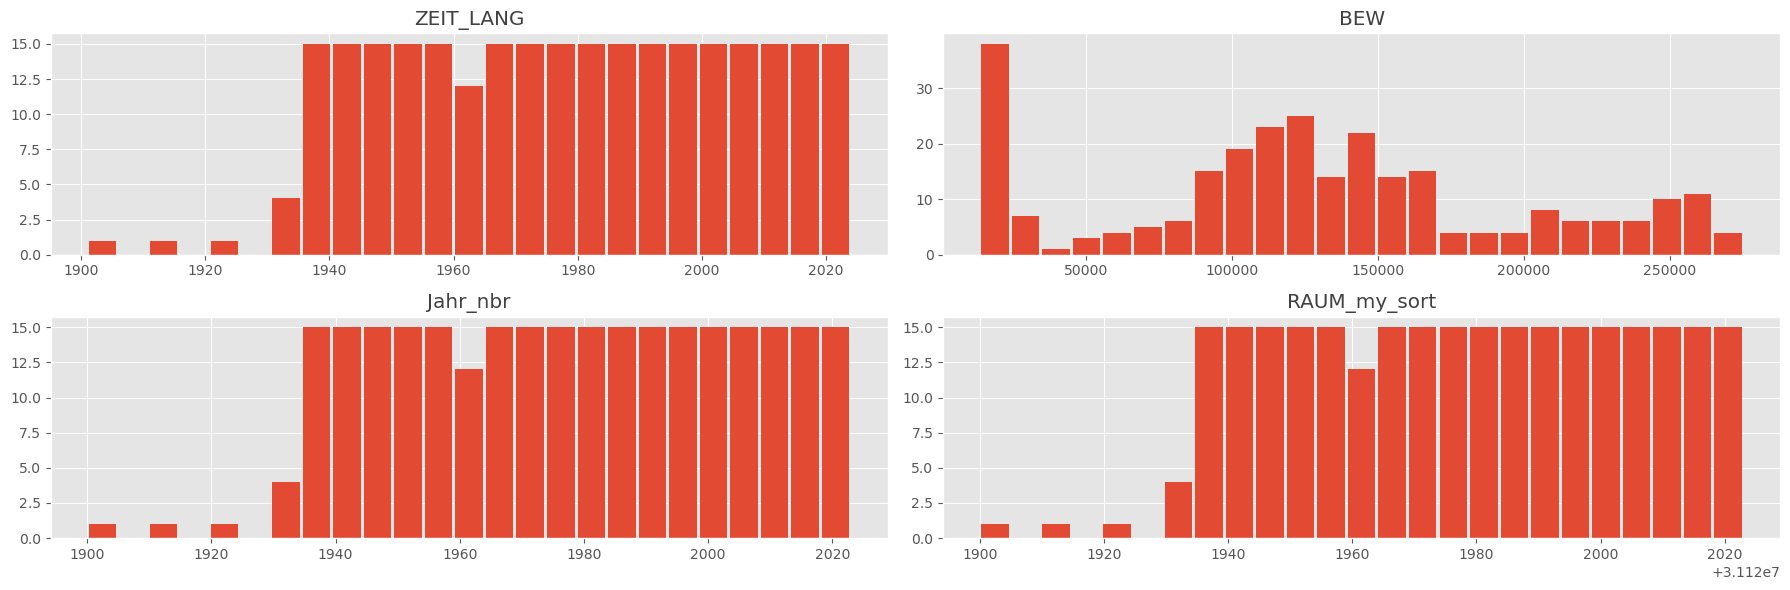

In [ ]:
plt.style.use('ggplot')
params = {
    'text.color': (0.25, 0.25, 0.25),
    'figure.figsize': [18, 6],
   }
plt.rcParams.update(params)

try:
    data2betested.hist(bins=25, rwidth=0.9)
    plt.tight_layout()
    plt.show()
except:
    print("No numercial data to plot.") 

### Gibt es Duplikate?

In [ ]:
# find duplicate rows
duplicate_rows = data2betested[data2betested.duplicated()]
duplicate_rows

,ZEIT_LANG,ZEIT_CODE,RAUM_LANG,RAUM_CODE,KON_LANG,KON_CODE,BEW,StichtagDatJahr_str,Jahr_nbr,RAUM_my_sort
StichtagDatJahr,,,,,,,,,,


### Nullwerte und Missings?

In [ ]:
data2betested.isnull().sum()

ZEIT_LANG              0
ZEIT_CODE              0
RAUM_LANG              0
RAUM_CODE              0
KON_LANG               0
KON_CODE               0
BEW                    0
StichtagDatJahr_str    0
Jahr_nbr               0
RAUM_my_sort           0
dtype: int64

In [ ]:
# check missing values with missingno
# https://github.com/ResidentMario/missingno
import missingno as msno
#msno.matrix(data2betested, labels=True, sort='descending');
#msno.heatmap(data2betested)

### Gruppierungen

In [ ]:
agg_jahr = data2betested.loc[data_min_date:data_max_date]\
    .groupby(['Jahr_nbr']) \
    .agg(sum_AnzBestWir=('BEW', 'sum')) \
    .sort_values('Jahr_nbr', ascending=False) 
agg_jahr.reset_index().head(3)

,Jahr_nbr,sum_AnzBestWir
0,2023,447082
1,2022,443037
2,2021,436332


In [ ]:
data2betested.RAUM_LANG.unique()

array(['Stadt Zürich (ab 1934)'], dtype=object)

In [ ]:
agg_Quarts = data2betested.loc[data_min_date:data_max_date]\
    .groupby(['Jahr_nbr','RAUM_LANG', 'RAUM_CODE']) \
    .agg(sum_AnzBestWir=('BEW', 'sum')) \
    .sort_values(['Jahr_nbr','RAUM_CODE'], ascending=[False, True]) 
agg_Quarts.reset_index().head(5)

,Jahr_nbr,RAUM_LANG,RAUM_CODE,sum_AnzBestWir
0,2023,Stadt Zürich (ab 1934),R30000,447082
1,2022,Stadt Zürich (ab 1934),R30000,443037
2,2021,Stadt Zürich (ab 1934),R30000,436332
3,2020,Stadt Zürich (ab 1934),R30000,434736
4,2019,Stadt Zürich (ab 1934),R30000,434008


In [ ]:
data2betested.columns

Index(['ZEIT_LANG', 'ZEIT_CODE', 'RAUM_LANG', 'RAUM_CODE', 'KON_LANG', 'KON_CODE', 'BEW',
       'StichtagDatJahr_str', 'Jahr_nbr', 'RAUM_my_sort'],
      dtype='object')

### Zeitpunkte und Zeiträume abfragen

A particular powerful feature of the Pandas DataFrame is its indexing capability that also works using time-based entities, such as dates and times. We have already created the index above, so let's put it to use.

In [ ]:
data2betested.loc[data_max_date].head(2)
#data2betested.loc["2021-10-31":"2021-11-30"].head(2)

,ZEIT_LANG,ZEIT_CODE,RAUM_LANG,RAUM_CODE,KON_LANG,KON_CODE,BEW,StichtagDatJahr_str,Jahr_nbr,RAUM_my_sort
StichtagDatJahr,,,,,,,,,,
2023-12-31,2023-12-31,Z31122023,Stadt Zürich (ab 1934),R30000,Evangelisch-reformierte Kirche,KON1001,74269,2023-12-31,2023,31122023
2023-12-31,2023-12-31,Z31122023,Stadt Zürich (ab 1934),R30000,Römisch-katholische Kirche,KON2001,97639,2023-12-31,2023,31122023


### Visualisierungen nach Zeitausschnitten

#### Entwicklung Wohnbevölkerung seit ...

In [ ]:
myAgg1 = data2betested.loc[data_min_date:data_max_date]\
    .groupby(['StichtagDatJahr','RAUM_LANG']) \
    .agg(sum_WBev=('BEW', 'sum')) \
    .sort_values('StichtagDatJahr', ascending=False) 

myAgg1.reset_index().head(1)

,StichtagDatJahr,RAUM_LANG,sum_WBev
0,2023-12-31,Stadt Zürich (ab 1934),447082


In [ ]:
grafik1 = mypy_dv.plot_altair_multiline_highlight(
    data = myAgg1.reset_index().query('sum_WBev>3')
    , x = 'StichtagDatJahr:T'
    , y = 'sum_WBev:Q'
    , x_beschriftung = 'Jahr'
    , y_beschriftung = 'Anz. Personen'
    , warning_status  = "ignore"
    , category=''
    , category_beschriftung='legende:'
    , myTitle="Bevölkerungsentwicklung, seit "+data_min_date    
)
grafik1

In [ ]:
grafic_name = package_name+"_alt1_total"+date_today+".png"
print('grafiken_testing/'+grafic_name)

grafik1.save('grafiken_testing/'+grafic_name)

grafiken_testing/bev316od3160alt1_total_2024-05-28.png


#### Barcharts mit Seaborn

In [ ]:
#myAgg = data2betested.loc["2008-11-30":"2021-10-31"]
myAggBar = data2betested.loc["2000":data_max_date]\
    .groupby(['StichtagDatJahr','Jahr_nbr', 'RAUM_LANG', 'RAUM_CODE','KON_LANG', 'KON_CODE']) \
    .agg(sum_WBev=('BEW', 'sum')) \
    .sort_values('StichtagDatJahr', ascending=True) 

myAggBar.reset_index().head(3)

,StichtagDatJahr,Jahr_nbr,RAUM_LANG,RAUM_CODE,KON_LANG,KON_CODE,sum_WBev
0,2000-12-31,2000,Stadt Zürich (ab 1934),R30000,"Andere, ohne, unbekannt",KON9900,124559
1,2000-12-31,2000,Stadt Zürich (ab 1934),R30000,Evangelisch-reformierte Kirche,KON1001,112513
2,2000-12-31,2000,Stadt Zürich (ab 1934),R30000,Römisch-katholische Kirche,KON2001,123908


In [ ]:
#Stile for the following sns graphs
sns.set_theme(style="whitegrid")

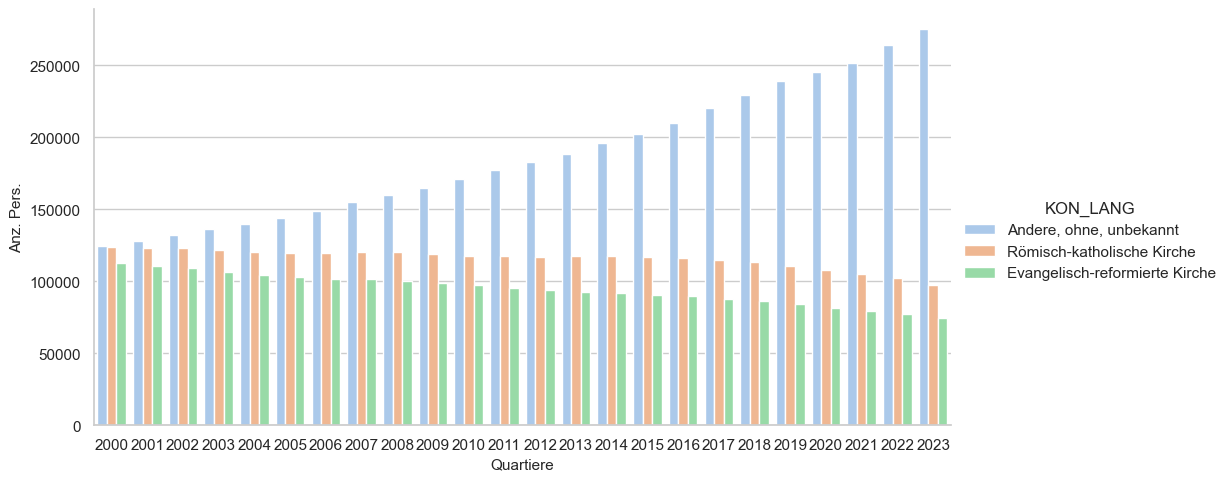

In [ ]:
#sns.color_palette("flare", as_cmap=True)
myHist = sns.catplot(x="Jahr_nbr"
            , y="sum_WBev"
            , hue="KON_LANG"
            , kind="bar" #boxen, violin, --> wenn die aggregation nicht genau den werten in der grafik entspricht
            , palette="pastel" #, color="green"
            , height=5
            , aspect=2
            , order=None, legend_out=True
            ,data=myAggBar.reset_index().sort_values("RAUM_CODE", ascending=True)
           )
myHist.set_xlabels('Quartiere', fontsize=11) # not set_label
myHist.set_ylabels('Anz. Pers.', fontsize=11)


#### Faced Grids

In [ ]:
data2betested.columns

Index(['ZEIT_LANG', 'ZEIT_CODE', 'RAUM_LANG', 'RAUM_CODE', 'KON_LANG', 'KON_CODE', 'BEW',
       'StichtagDatJahr_str', 'Jahr_nbr', 'RAUM_my_sort'],
      dtype='object')

In [ ]:
myFG1 = data2betested.loc[data_min_date:data_max_date]\
    .groupby(['Jahr_nbr','StichtagDatJahr_str', 'RAUM_LANG', 'RAUM_CODE', 'RAUM_my_sort', 'KON_LANG', 'KON_CODE']) \
    .agg(sum_WBev=('BEW', 'sum')) \
    .sort_values('RAUM_my_sort', ascending=True) 

myFG1.head(2)

,,,,,,,sum_WBev
Jahr_nbr,StichtagDatJahr_str,RAUM_LANG,RAUM_CODE,RAUM_my_sort,KON_LANG,KON_CODE,
1900,1900-12-31,Stadt Zürich (ab 1934),R30000,31121900,Evangelisch-reformierte Kirche,KON1001,116555
1910,1910-12-31,Stadt Zürich (ab 1934),R30000,31121910,Evangelisch-reformierte Kirche,KON1001,139649


In [ ]:
faced_grid1 = mypy_dv.plot_sns_facetgrid(
    data = myFG1.reset_index()
    , col = "KON_LANG"
    , hue = "KON_LANG"
    , col_wrap = 4
    , height = 3
    , grafiktyp = sns.lineplot
    , x = "Jahr_nbr"
    , xlabel = ''
    , y = "sum_WBev"
    , ylabel= "Anzahl Personen"
    , warning_status ="always"
    , myTitle="Entwicklung der Konfessioen, seit "+str(data2betested.index.year.min())
)

faced_grid1 

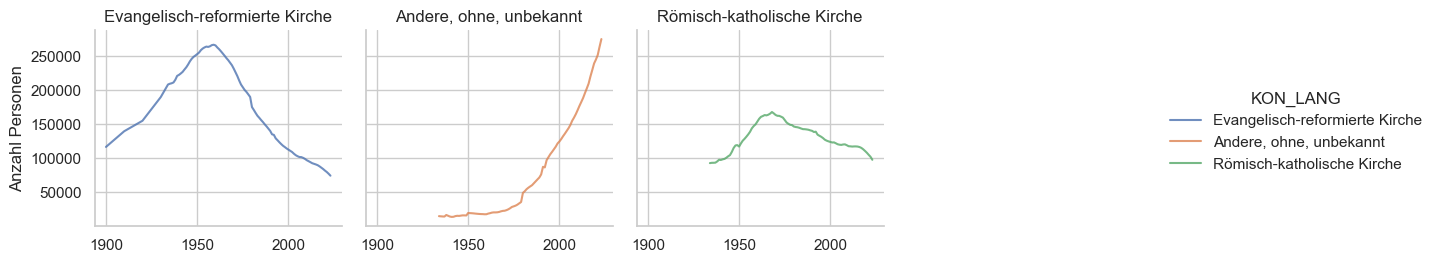

In [ ]:
grafic_name = package_name+"_fg_konf_zeit_"+date_today+".png"

print('grafiken_testing/'+grafic_name)


faced_grid1.savefig('grafiken_testing/'+grafic_name)

Hinweis:
Die Warnings kommen daher, dass die sehr alten Werte zu inf (also NaT) definiert wurden...



In [ ]:
data2betested.replace([float('inf'), float('-inf')], pd.NA, inplace=True)

In [ ]:
mypy_dv.plot_sns_facetgrid(data, col, hue, col_wrap, height, grafiktyp, x, xlabel, y, ylabel, warning_status)

## ---------------------- hier Plausi beendet

Übersicht zu LOSD-Jobs:
[Sharepoint](https://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/OGD%20Metadaten.aspx#InplviewHasheb69a2c0-ed94-4ef2-91a5-3b19f038e442=FilterField1%3DMetadaten%255Fx002d%255FPublikations%255Fx00-FilterValue1%3DINT)